# 0. Set Blocksci

In [1]:
import blocksci
import time
import numpy as np
from path_related_tool_box.path_cascade_prepare import *
from path_related_tool_box.path_graph_prepare import *
from path_related_tool_box.address_feat_prepare import *
from path_related_tool_box.path_visualization import *


visual_switch =True
global_end_height = 610637
config_path = '/home/extra_HDD_2/blocksci_made_data_bk_up_2/btc_config.json'
main_blk_chain = blocksci.Blockchain(config_path)
addr_type_dict = {'0': blocksci.address_type.nonstandard,
                  '1': blocksci.address_type.pubkey,
                  '2': blocksci.address_type.pubkeyhash,
                  '3': blocksci.address_type.multisig_pubkey,
                  '4': blocksci.address_type.scripthash,
                  '5': blocksci.address_type.multisig,
                  '6': blocksci.address_type.nulldata,
                  '7': blocksci.address_type.witness_pubkeyhash,
                  '8': blocksci.address_type.witness_scripthash}

# 1. User specify address Hash

In [2]:
hash_str = 'bc1q93ecep2338dy9aauwyvh4g22t49rnedxl8z0tj' # <-- Can Change Here !
picked_addr = main_blk_chain.address_from_string(hash_str)
picked_node_id = picked_addr.address_num*10+picked_addr.raw_type
birth_height = picked_addr.first_tx.block_height
research_end_height = min(global_end_height, birth_height + 24 * 6)

# 2. Data Preparation
## 2.0 Fetch Address Feature

In [3]:
tmp_save_path = './tmp_Path_Graph_data/'
address_feature_prepare(main_blk_chain, picked_addr, picked_node_id, tmp_save_path)

Sample Size : 1 / Feature Shape: (1, 16)


## 2.1 Fetch Asset Transfer Path

In [4]:
forward_path = tmp_save_path + f'forward_{picked_node_id}.json'
backward_path = tmp_save_path + f'backward_{picked_node_id}.json'
path_prepare(main_blk_chain, picked_addr, research_end_height, forward_path, backward_path)

Forward tx num : 1
Forward Max 6 hops  
Forward Fetching cost 0.01 s

Backward tx num : 1
Backward Max -5 hops
Backward Fetching cost 0.07 s



Forward Asset Transer Path
------------- Building Graph -------------
Source Node num is 1
node number is 7
Node num is 7
------------ Plotting Done ------------
Backward Asset Transer Path
------------- Building Graph -------------
Source Node num is 1
node number is 54
Node num is 54
------------ Plotting Done ------------


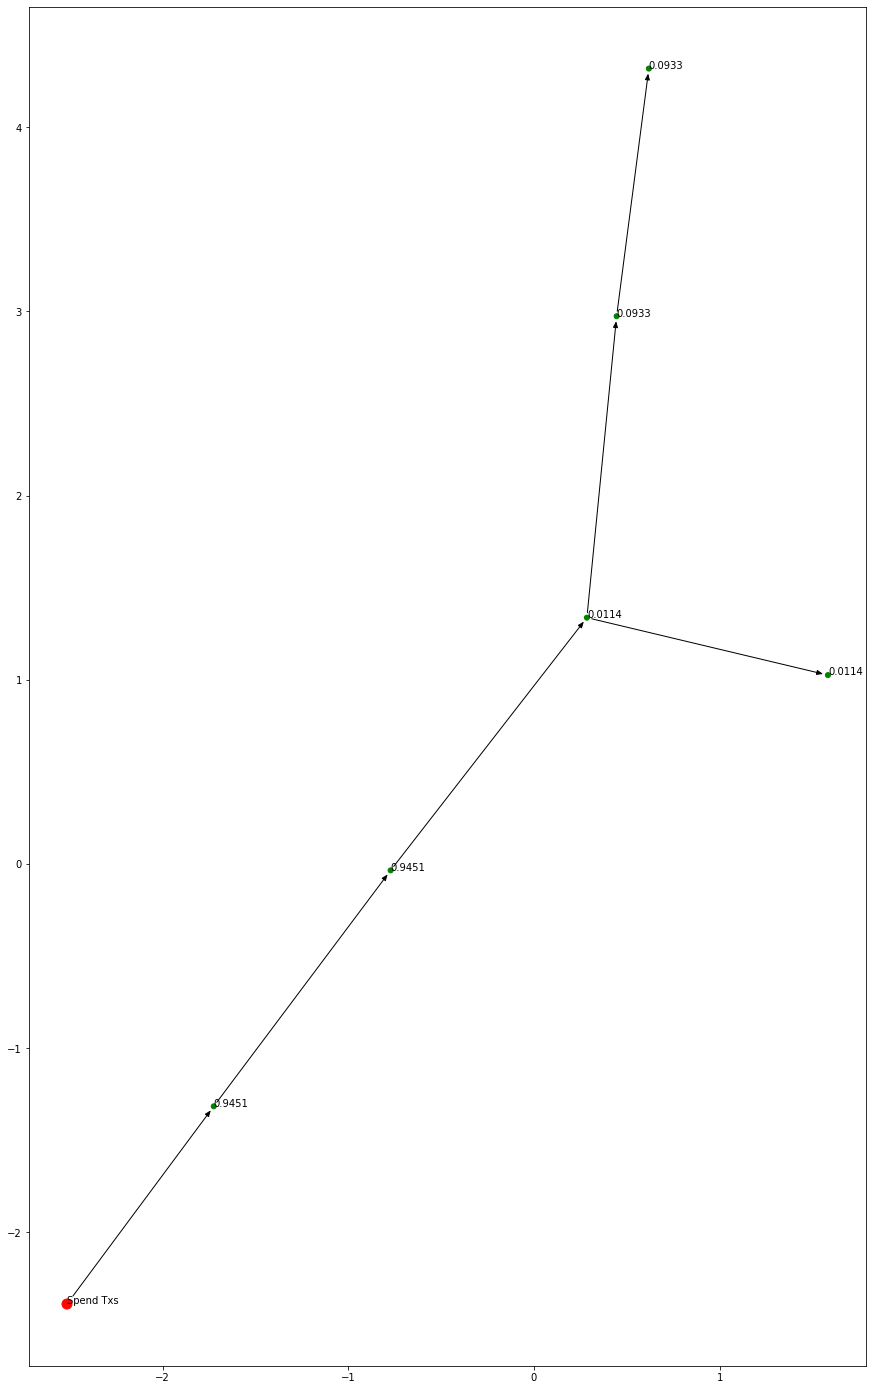

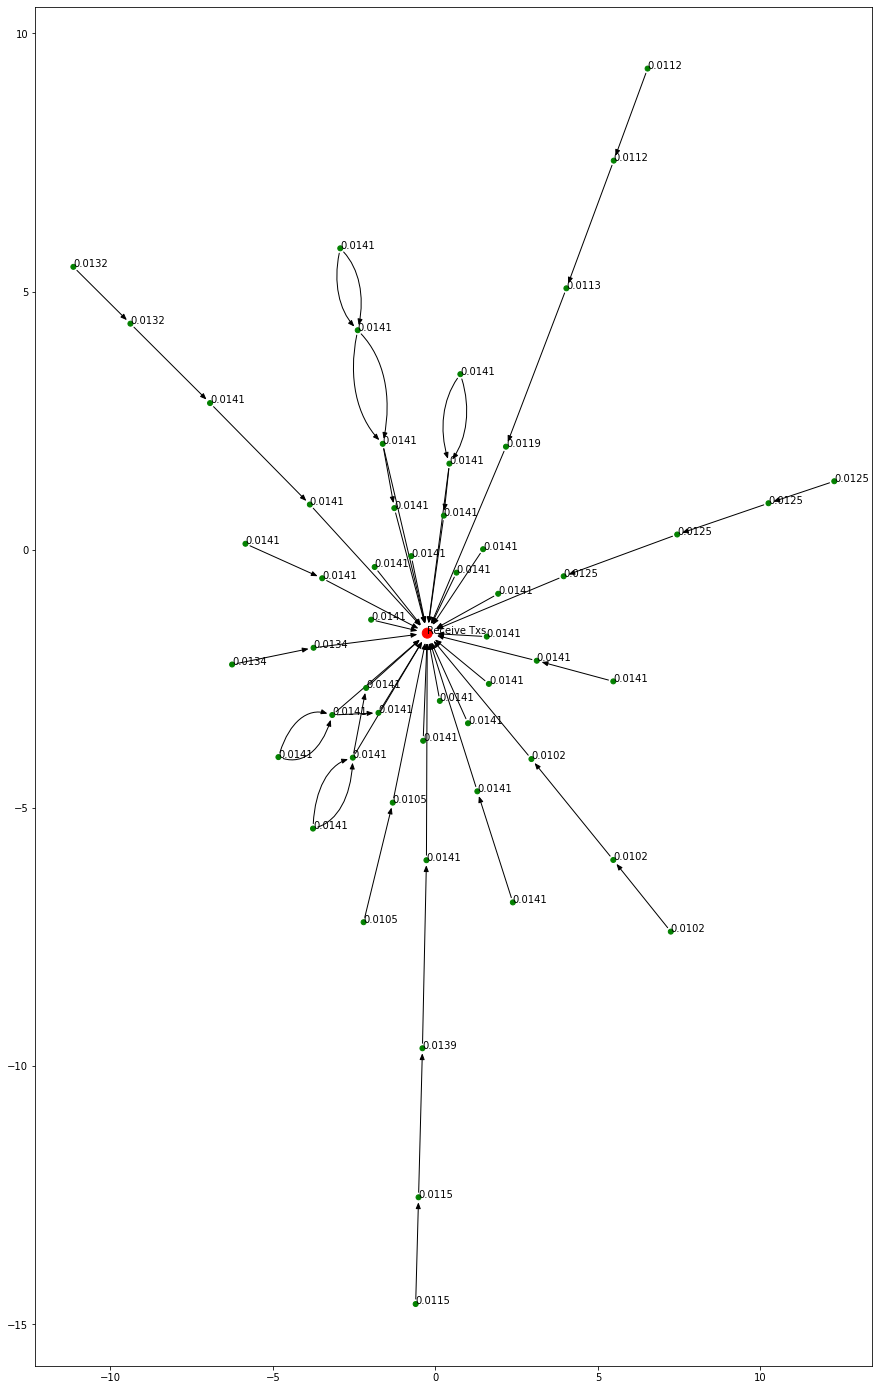

In [5]:
if visual_switch:
    # Green nodes are transactions
    # Red nodes are address-related transaction set --> We merge all address-related transaction for visual clarity
    # Number beside the node is the activation score
    
    print('Forward Asset Transer Path')
    path_plot('forward', forward_path)
    
    print('Backward Asset Transer Path')
    path_plot('backward', backward_path)

## 2.2 Prepare Path Feature

In [6]:
for direction in ['backward', 'forward']:
    file_path = tmp_save_path + f'{direction}_{picked_node_id}.json'
    save_path = tmp_save_path + f'{direction}_{picked_node_id}_feat.npz'
    this_direct_early_path = early_path_processor(main_blk_chain, file_path, picked_addr, direction, birth_height)
    if this_direct_early_path == [[] for i in range(6, int(24 * 6), 6)]:
        raise ValueError('Address behavior not compatible for early detection')
    np.savez_compressed(save_path, np.array(this_direct_early_path, dtype=object))

## 2.3 Fetch Asset Transfer Path Graph

In [7]:
min_height = birth_height - int(24 * 6)
max_height = birth_height + int(24 * 6)

for direction in ['backward', 'forward']:
    feat_file = tmp_save_path + f'{direction}_{picked_node_id}_feat.npz'
    path_intersect_file = tmp_save_path + f'{direction}_{picked_node_id}_intsct_feat.npz'

    ST_path_feat = np.load(feat_file, allow_pickle=True)['arr_0']
    ST_path = [[]] * len(ST_path_feat)
    for hour_idx in range(len(ST_path_feat)):
        this_hour_path = []
        for path_feat in ST_path_feat[hour_idx]:
            this_hour_path.append(np.array(path_feat[:, 0].tolist(), dtype=np.int32).tolist())
        ST_path[hour_idx] = copy.deepcopy(this_hour_path)

    interact_info_at_diff_hour, bad_flag = intersection_prepare(main_blk_chain, ST_path, direction, min_height, max_height)
    if bad_flag: raise ValueError('Address behavior not compatible for early detection')
    np.savez_compressed(path_intersect_file, np.array(interact_info_at_diff_hour, dtype=object))